# Comparison of MSB with counting simple cycles 

In [1]:
import random
import pickle
import gzip
from pathlib import Path
import numpy as np
import pandas as pd
import igraph as ig
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from msb import Balance
from msb.cycleindex import balance_ratio

#%matplotlib inline
sns.set_theme(
    context="notebook",
    style="ticks",
    font_scale=1.3,
    palette="deep"
)

# COLORS = np.array(["#7aa063", "#c86b57", "#9d6ebd"])
COLORS = np.array(["#c76674", "#9a9945", "#8961b3"])
RED    = "#f97959"
BLUE   = "#60a1f7"
GRAY   = "#efefef"

# Paths
HERE = Path(".").absolute()
ROOT = HERE.parent.parent
DATA = ROOT/"data"
FIGS = ROOT/"figs"
FIGS.mkdir(exist_ok=True)

# Balance params
BKWS = dict(m=None)

# Network datasets
LABELS = {
    "new-guinea-tribes":   "Tribes",
    "sampson/t1":          "Monks (1)",
    "sampson/t2":          "Monks (2)",
    "sampson/t3":          "Monks (3)",
    "sampson/t4":          "Monks (4)",
    "sampson/t5":          "Monks (5)",
}
NETWORKS = {
    name: ig.Graph.Read_GraphMLz(DATA/f"{label}.graphml.gz")
    for label, name in LABELS.items()
}


/home/sztal/miniconda3/envs/msb/lib/python3.10/site-packages/igraph/io/files.py:189: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:492
  return cls.Read_GraphML(tmpfile, index=index)


In [2]:
def relerr(x, y):
    return np.abs((x - y) / y).mean()

def corr(x, y, **kwds):
    return pd.DataFrame({"x": x, "y": y}).corr(**kwds).loc["x", "y"]


In [3]:
def get_A(graph: ig.Graph) -> np.ndarray:
    """Get adjacency array."""
    return np.array([*graph.get_adjacency(attribute="weight")])

BALANCE = {
    k: Balance(v, **BKWS)
    for k, v in tqdm(NETWORKS.items())
}
CYCLES  = {
    k: balance_ratio(get_A(v), exact=True, length=v.vcount())
    for k, v in tqdm(NETWORKS.items())
}


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [4]:
data = []
for name, B in BALANCE.items():
    cycle = np.clip(1-CYCLES[name], 0, 1)
    K = B.K(kmax=B.n_nodes)
    msb = B.k_balance(K=K)
    contrib = B.contrib(K=K)
    df = pd.DataFrame({
        "cycle":   cycle[-K.size:],
        "msb":     msb,
        "contrib": contrib.to_numpy()
    }, index=pd.Series(K, name="K"))
    data.append(df)

data = pd.concat(data, keys=pd.Series(list(BALANCE), name="name"))


/home/sztal/miniconda3/envs/msb/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/sztal/miniconda3/envs/msb/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/sztal/miniconda3/envs/msb/lib/python3.10/site-packages/pandas/core/internals/managers.py:1835: ComplexWarning: Casting complex values to real discards the imaginary part
  result[rl.indexer] = arr
/home/sztal/miniconda3/envs/msb/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/sztal/miniconda3/envs/msb/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/sztal/miniconda3/envs/msb/l

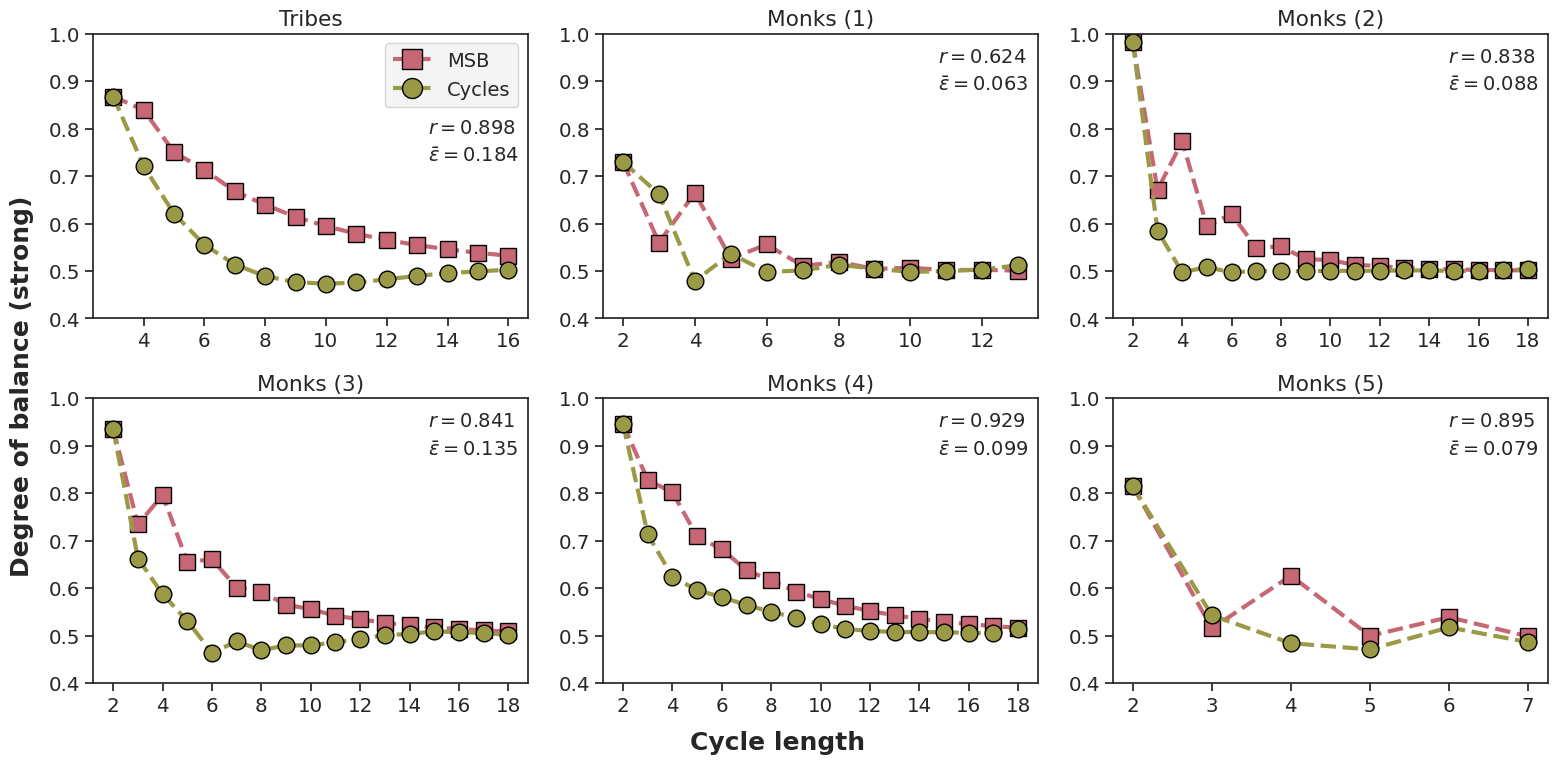

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))

for ax, group in zip(axes.flatten(), data.groupby(level="name", sort=False)):
    name, gdf = group
    K = gdf.index.get_level_values("K")
    kws = {"ls": "--", "lw": 3, "markersize": 12, "markeredgecolor": "black"}
    ax.plot(K, gdf["msb"], marker="s", color=COLORS[0], **kws, label="MSB")
    ax.plot(K, gdf["cycle"], marker="o", color=COLORS[1], **kws, label="Cycles")
    ax.set_title(name)
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    ax.set_ylim(.4, 1)
    # Correlation
    r = corr(gdf["msb"], gdf["cycle"])
    error = relerr(gdf["msb"], gdf["cycle"])
    # Legend and annotations
    t1 = rf"$r = {r:.3f}$"
    t2 = rf"$\bar{{\epsilon}} = {error:.3f}$"
    akws = {"fontsize": 14, "transform": ax.transAxes}
    if name == "Tribes":
        ax.text(.77, .65, t1, **akws)
        ax.text(.77, .55, t2, **akws)
        ax.legend(fontsize=14, markerscale=1.2, facecolor="#f2f2f2")
    else:
        ax.text(.77, .9, t1, **akws)
        ax.text(.77, .8, t2, **akws)

fonts = {"fontsize": 18, "fontweight": "bold"}
fig.supxlabel("Cycle length", y=.04, **fonts)
fig.supylabel("Degree of balance (strong)", **fonts)
fig.tight_layout()
fig.savefig(FIGS/"perf-cycles-small.pdf", bbox_inches="tight")


In [6]:
with gzip.open("cycles-10000.pkl.gz", "rb") as fh:
    congress = pickle.load(fh)

dob = {}
cyc = {}

for k, v in congress.items():
    ddf = pd.concat([
        dct["dob"] for dct in v
    ], axis=1)
    cdf = pd.concat([
        pd.Series(dct["cycles"][-len(ddf):], index=ddf.index)
        for dct in v
    ], axis=1)
    dob[k] = ddf.T.reset_index(drop=True)
    cyc[k] = cdf.T.reset_index(drop=True)


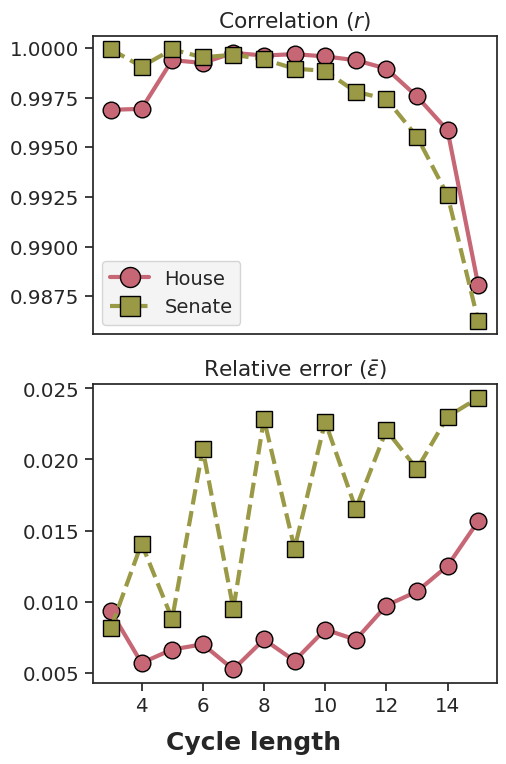

In [7]:
fig, axes = plt.subplots(nrows=len(congress), figsize=(16/3, 8))

for ls, marker, chamber in zip(("-", "--"), ("o", "s"), congress):
    d = dob[chamber]
    c = cyc[chamber]
    K = d.columns
    r = [ corr(d[k], c[k]) for k in K ]
    e = [ relerr(d[k], c[k]) for k in K ]

    kws = {"lw": 3, "markersize": 12, "markeredgecolor": "black"}
    label = "House" if chamber == "H" else "Senate"
    color = COLORS[0] if chamber == "H" else COLORS[1]
    axes[0].plot(K, r, ls=ls, color=color, marker=marker, label=label, **kws)
    axes[1].plot(K, e, ls=ls, color=color, marker=marker, label=label, **kws)

for title, ax in zip((r"Correlation", r"Relative error"), axes):
    ylab = "$r$" if title == "Correlation" else r"$\bar{\epsilon}$"
    ax.set_title(f"{title} ({ylab})")
axes[0].legend(fontsize=14, markerscale=1.2, facecolor="#f2f2f2")
axes[0].tick_params(
    axis="x",
    which="both",
    bottom=False,
    top=False,
    labelbottom=False
)
axes[1].xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))

fig.supxlabel("Cycle length", y=0.04, **fonts)
fig.tight_layout()
fig.savefig(FIGS/"perf-cycles-congress.pdf", bbox_inches="tight")
